In [1]:
# Standard libraries
import time
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV, PredefinedSplit, KFold, StratifiedKFold, train_test_split, cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
)

from Preprocessing_functions import *

import importlib
imported_module = importlib.import_module("Preprocessing_functions2")
importlib.reload(imported_module)

# pandas max columns display
pd.set_option('display.max_columns', None)

## Import Dataset

In [2]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_53298/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [3]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [4]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached','OIICS Nature of Injury Description'])
y = train_data['Claim Injury Type']

test_data = test_data.drop(columns=['OIICS Nature of Injury Description'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

____

# Auxiliary Functions


## List creation for preprocessing

In [5]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']

numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']


columns_to_scale = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                'Age at Injury',
                'Birth Year', 
                'Number of Dependents',
                'IME-4 Count']

date_columns = ['Accident Date', 'Assembly Date']

outliers_iqr_specific = ['Age at Injury', 'Birth Year']

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X[col].nunique() > 10]

## Preprocess Functions

In [305]:
binning2_columns = ['Age at Injury', 'Age at Injury', 'Birth Year', 'Average Weekly Wage', 'IME-4 Count']
date_columns = ['Accident Date', 'Assembly Date']

def create_groupingFeatures(X_train, X_val):

    categorical_features = []
    numerical_features = []

    X_train, X_val= newFeature_binnedGroups(X_train, X_val, binning2_columns, 6)
    # Add all names of the binning_column + 'Group' to the list of categorical_features
    for col in binning2_columns:
        categorical_features.append(col + ' Group')
        X_train[f'{col} Group'].astype(str)
        X_val[f'{col} Group'].astype(str)

    X_train, X_val = newFeature_month(X_train, X_val, date_columns)
    # Add all names of the date_columns + 'Month' to the list of categorical_features
    for col in date_columns:
        categorical_features.append(col + ' Month')
        X_train[f'{col} Month'].astype(str)
        X_val[f'{col} Month'].astype(str)



    X_train, X_val = newFeature_daysBetween(X_train, X_val, firstDate='Accident Date', secondDate='Assembly Date')
    numerical_features.append('Days Between Accident Date and Assembly Date')
    
    return X_train, X_val, categorical_features, numerical_features

In [6]:


def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = log_transform(X_train, X_val)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[0], 14)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[1], 1934)
    X_train, X_val = scaling_robust(X_train, X_val, columns_to_scale)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

In [307]:
def preprocessing_newFeatures_advanced(X_train, X_val):

    # Type conversion
    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)

    

    # Knowledge-based imputation of features
    X_train, X_val = fill_missing_codes_description_based(X_train, X_val)
    X_train, X_val = fillna_zip_code(X_train, X_val)
    X_train, X_val = fillnan_accident_date(X_train, X_val)
    X_train, X_val = fillnan_birth_year(X_train, X_val)
    X_train, X_val = impute_weekly_wage_with_zipIndustryCode(X_train, X_val)
    X_train, X_val = fillnan_IME4_count(X_train, X_val)

    # Impute still missing values
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)

    

    # Feature creation
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = newFeature_hasIME4(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)
    #X_train, X_val = convert_to_datetime(X_train, X_val, date_columns)

    # # Grouping features
    # X_train, X_val, c_features, n_features= create_groupingFeatures(X_train, X_val)
    # categorical_features.append(c_features)
    # numerical_columns.append(n_features)

    # Redo type conversion
    #X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    #X_train, X_val = convert_to_timestamp(X_train, X_val, date_columns)

    # Treating outliers
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)

    # Scaling
    X_train, X_val = scaling_robust(X_train, X_val, binning2_columns)
    X_train, X_val = scaling_robust(X_train, X_val, date_columns)

    # # Ensure categorical_features contains unique column names
    # valid_categorical_features = list(set(categorical_features))

    # # Verify all columns in categorical_features exist in X_train
    # valid_categorical_features = [col for col in valid_categorical_features if col in X_train.columns]
    # print(f'Valid categorical features: {valid_categorical_features}')


    low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 15]
    high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 15]

    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

# Feature Selection


## lasso regresion 

In [11]:
X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions2.py:432: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions2.py:433: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never wor

c:\Users\timst\anaconda3\envs\DM2425_20241209\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\timst\anaconda3\envs\DM2425_20241209\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\timst\anaconda3\envs\DM2425_20241209\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\timst\anaconda3\envs\DM2425_20241209\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\timst\anaconda3\envs\DM2425_20241209\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Us

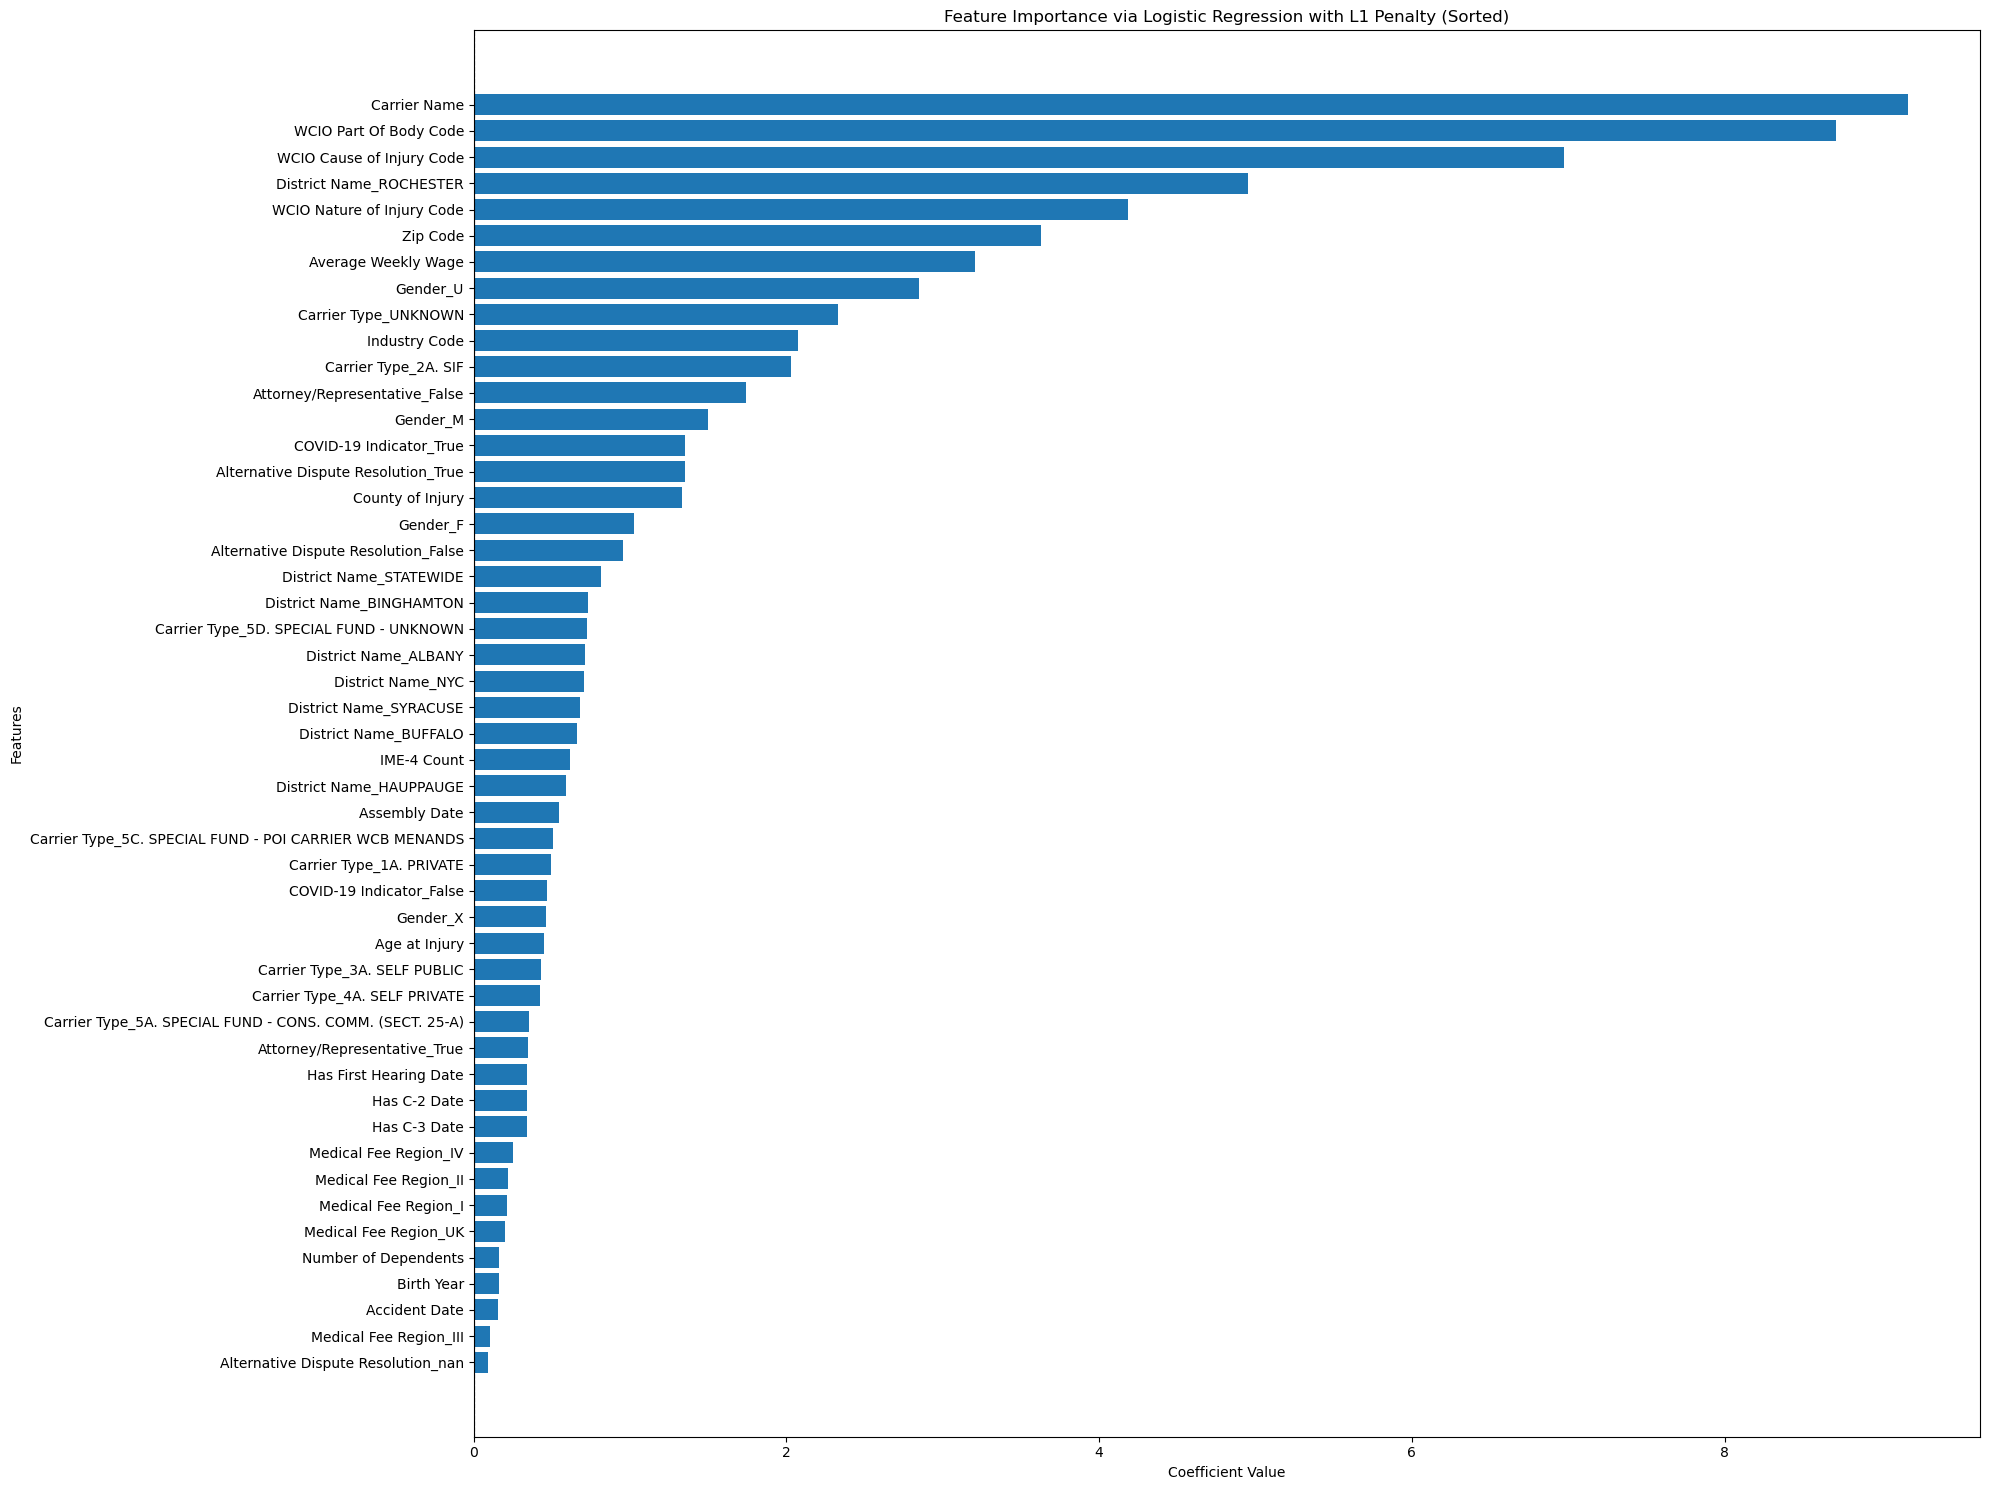

Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Has C-3 Date', 'Has C-2 Date', 'Has First Hearing Date', 'Alternative Dispute Resolution_False', 'Alternative Dispute Resolution_True', 'Alternative Dispute Resolution_nan', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)', 'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS', 'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Gender_F', 'Gender_M', 'Gender_U', 'Gender_X', 'M

In [261]:
logreg_cv = LogisticRegressionCV(
    penalty='l1',
    solver='saga', 
    Cs=5,
    cv=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    scoring='f1_macro',
    max_iter=2000
)
logreg_cv.fit(X_train, y_train)

# Identify selected and unselected features
if len(logreg_cv.coef_.shape) > 1:
    coefs = np.abs(logreg_cv.coef_).mean(axis=0)
else:
    coefs = logreg_cv.coef_.flatten()

selected_features = X_train.columns[coefs != 0].tolist()
unselected_features = X_train.columns[coefs == 0].tolist()

# Plot feature importance
sorted_idx = np.argsort(np.abs(coefs))
sorted_features = X_train.columns[sorted_idx]
sorted_coefs = coefs[sorted_idx]

# Create sorted bar plot
plt.figure(figsize=(20, 15))
plt.barh(sorted_features, sorted_coefs)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Importance via Logistic Regression with L1 Penalty (Sorted)")
plt.axvline(0, color="black", linewidth=0.8, linestyle="--")
plt.tight_layout()
plt.show()

# Output selected and unselected features
print("Selected Features:", selected_features)
print("Unselected Features:", unselected_features)


In [309]:
# put features together with there coefficients
feature_importance = pd.DataFrame({'Feature': sorted_features, 'Coefficient': sorted_coefs})
feature_importance

,Feature,Coefficient
0,Alternative Dispute Resolution_nan,0.091208
1,Medical Fee Region_III,0.104723
2,Accident Date,0.156352
3,Birth Year,0.161018
4,Number of Dependents,0.162521
5,Medical Fee Region_UK,0.199784
6,Medical Fee Region_I,0.211184
7,Medical Fee Region_II,0.218863
8,Medical Fee Region_IV,0.251852
9,Has C-3 Date,0.339323


| Feature                                | Coefficient |
|----------------------------------------|-------------|
| Alternative Dispute Resolution_nan     | 0.091208    |
| Medical Fee Region_III                 | 0.104723    |
| Accident Date                          | 0.156352    |
| Birth Year                             | 0.161018    |
| Number of Dependents                   | 0.162521    |
| Medical Fee Region_UK                  | 0.199784    |
| Medical Fee Region_I                   | 0.211184    |
| Medical Fee Region_II                  | 0.218863    |
| Medical Fee Region_IV                  | 0.251852    |
| Has C-3 Date                           | 0.339323    |
| Has C-2 Date                           | 0.339323    |
| Has First Hearing Date                 | 0.339323    |
| Attorney/Representative_True           | 0.344442    |
| Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S... | 0.354133    |
| Carrier Type_4A. SELF PRIVATE          | 0.426216    |
| Carrier Type_3A. SELF PUBLIC           | 0.427759    |
| Age at Injury                          | 0.448413    |
| Gender_X                               | 0.459640    |
| COVID-19 Indicator_False               | 0.469610    |
| Carrier Type_1A. PRIVATE               | 0.495387    |
| Carrier Type_5C. SPECIAL FUND - POI CARRIER WC... | 0.506768    |
| Assembly Date                          | 0.543958    |
| District Name_HAUPPAUGE               | 0.592683    |
| IME-4 Count                            | 0.615296    |
| District Name_BUFFALO                 | 0.658296    |
| District Name_SYRACUSE                | 0.679366    |
| District Name_NYC                     | 0.706079    |
| District Name_ALBANY                  | 0.709348    |
| Carrier Type_5D. SPECIAL FUND - UNKNOWN | 0.721796    |
| District Name_BINGHAMTON              | 0.733356    |
| District Name_STATEWIDE               | 0.814429    |
| Alternative Dispute Resolution_False  | 0.955822    |
| Gender_F                               | 1.027072    |
| County of Injury                       | 1.331568    |
| Alternative Dispute Resolution_True   | 1.348975    |
| COVID-19 Indicator_True               | 1.349827    |
| Gender_M                               | 1.498185    |
| Attorney/Representative_False         | 1.740615    |
| Carrier Type_2A. SIF                  | 2.027552    |
| Industry Code                          | 2.075674    |
| Carrier Type_UNKNOWN                  | 2.330205    |
| Gender_U                               | 2.846922    |
| Average Weekly Wage                    | 3.204603    |
| Zip Code                               | 3.625286    |
| WCIO Nature of Injury Code            | 4.186389    |
| District Name_ROCHESTER               | 4.952202    |
| WCIO Cause of Injury Code             | 6.970056    |
| WCIO Part Of Body Code                | 8.713728    |
| Carrier Name                           | 9.174048    |


## RFECV with preprocessing_scaling_encoding_dum

In [ ]:
y_train, y_val = encoding_label(y_train, y_val) 

c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:432: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  def impute_weekly_wage_with_zipIndustryCode(X_train, X_val):
c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:433: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi

In [ ]:
 # Initialize RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=15,                # Limit tree depth
    min_samples_split=50,        # Minimum samples for a split
    min_samples_leaf=20,         # Minimum samples per leaf
    max_features='sqrt',         # Features to consider per split
    class_weight='balanced',     # Handle class imbalance
    bootstrap=True,              # Use bootstrapping
    random_state=42,             # Ensure reproducibility
    n_jobs=-1                    # Use all CPU cores
)

# Set up cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up RFECV with RandomForest and cross-validation
rfecv = RFECV(estimator=rf_model, step=1, cv=cv_strategy, scoring='f1_macro') 

# Fit RFECV
rfecv.fit(X_train, y_train)

#Get the selected features
selected_features_RF = X_train.columns[rfecv.support_].tolist()
optimal_num_features = rfecv.n_features_
feature_ranking = rfecv.ranking_

print("Optimal number of features:", optimal_num_features)
print("Selected Features:", selected_features_RF)

Optimal number of features: 25
Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_IV', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']


In [ ]:
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': feature_ranking})
Optimal_number_of_features = 25

In [ ]:
selected_features = ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_IV', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']

Optimal number of features: 25

| Feature                                      | Ranking |
|----------------------------------------------|---------|
| Accident Date                                | 1       |
| Age at Injury                                | 1       |
| Assembly Date                                | 1       |
| Average Weekly Wage                          | 1       |
| Birth Year                                   | 1       |
| IME-4 Count                                  | 1       |
| Number of Dependents                         | 1       |
| Attorney/Representative_False               | 1       |
| Attorney/Representative_True                | 1       |
| Carrier Type_1A. PRIVATE                     | 1       |
| Carrier Type_2A. SIF                         | 1       |
| Carrier Type_3A. SELF PUBLIC                 | 1       |
| COVID-19 Indicator_False                     | 1       |
| COVID-19 Indicator_True                      | 1       |
| District Name_NYC                            | 1       |
| Gender_F                                     | 1       |
| Gender_M                                     | 1       |
| Medical Fee Region_IV                        | 1       |
| Carrier Name                                 | 1       |
| County of Injury                             | 1       |
| Industry Code                                | 1       |
| WCIO Cause of Injury Code                    | 1       |
| WCIO Nature of Injury Code                   | 1       |
| WCIO Part Of Body Code                       | 1       |
| Zip Code                                     | 1       |
| Medical Fee Region_I                         | 2       |
| District Name_BUFFALO                        | 3       |
| Medical Fee Region_II                        | 4       |
| District Name_ALBANY                         | 5       |
| District Name_HAUPPAUGE                      | 6       |
| Medical Fee Region_UK                        | 7       |
| Medical Fee Region_III                       | 8       |
| District Name_STATEWIDE                      | 9       |
| District Name_SYRACUSE                       | 10      |
| Carrier Type_4A. SELF PRIVATE                | 11      |
| Alternative Dispute Resolution_False         | 12      |
| District Name_BINGHAMTON                     | 13      |
| District Name_ROCHESTER                      | 14      |
| Alternative Dispute Resolution_True          | 15      |
| Carrier Type_5D. SPECIAL FUND - UNKNOWN      | 16      |
| Carrier Type_UNKNOWN                         | 17      |
| Gender_U                                     | 18      |
| Carrier Type_5A. SPECIAL FUND - CONS. COMM...| 19      |
| Has C-2 Date                                 | 20      |
| Carrier Type_5C. SPECIAL FUND - POI CARRIE...| 21      |
| Has First Hearing Date                       | 22      |
| Has C-3 Date                                 | 23      |
| Alternative Dispute Resolution_nan           | 24      |
| Gender_X                                     | 25      |


## RFECV with preprocessing_newFeatures_advanced

In [153]:
X_train, X_val = preprocessing_newFeatures_advanced(X_train, X_val)
y_train, y_val = encoding_label(y_train, y_val) 

c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:619: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Accident Date'].fillna(X_train['C-2 Date'] - mean_difference_c2_accident, inplace=True)
c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:620: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The beh

In [155]:
 # Initialize RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Set up cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5)

# Set up RFECV with RandomForest and cross-validation
rfecv = RFECV(estimator=rf_model, step=1, cv=cv_strategy, scoring='f1_macro', n_jobs=-1) 

# Fit RFECV
rfecv.fit(X_train, y_train)

#Get the selected features
selected_features_RF = X_train.columns[rfecv.support_].tolist()
feature_ranking = rfecv.ranking_
optimal_num_features = rfecv.n_features_

print("Optimal number of features:", optimal_num_features)
print("Feature Ranking:", feature_ranking)
print("Selected Features:", selected_features_RF)

Optimal number of features: 38
Feature Ranking: [ 1  1  1  1  1 13  1 12 11 10  9  1  3  8  1  1  1  1  1  1  7  6  4  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  5  1  1  1  1  1  1  1  1  1  1
  1  1]
Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'Number of Dependents', 'Alternative Dispute Resolution_False', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Carrier Na

In [ ]:
#create the feature ranking wee the features and the ranking are together
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': feature_ranking})
optimal_num_features_advanced = 46

In [ ]:
selected_featuer_advanced_rf = ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'Number of Dependents', 'Alternative Dispute Resolution_False', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Feature</th>
      <th>Ranking</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Accident Date</td>
      <td>1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Age at Injury</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Assembly Date</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Average Weekly Wage</td>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Birth Year</td>
      <td>1</td>
    </tr>
    <tr>
      <th>5</th>
      <td>IME-4 Count</td>
      <td>1</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Number of Dependents</td>
      <td>1</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Has C-3 Date</td>
      <td>23</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Has C-2 Date</td>
      <td>20</td>
    </tr>
    <tr>
      <th>9</th>
      <td>Has First Hearing Date</td>
      <td>22</td>
    </tr>
    <tr>
      <th>10</th>
      <td>Alternative Dispute Resolution_False</td>
      <td>12</td>
    </tr>
    <tr>
      <th>11</th>
      <td>Alternative Dispute Resolution_True</td>
      <td>15</td>
    </tr>
    <tr>
      <th>12</th>
      <td>Alternative Dispute Resolution_nan</td>
      <td>24</td>
    </tr>
    <tr>
      <th>13</th>
      <td>Attorney/Representative_False</td>
      <td>1</td>
    </tr>
    <tr>
      <th>14</th>
      <td>Attorney/Representative_True</td>
      <td>1</td>
    </tr>
    <tr>
      <th>15</th>
      <td>Carrier Type_1A. PRIVATE</td>
      <td>1</td>
    </tr>
    <tr>
      <th>16</th>
      <td>Carrier Type_2A. SIF</td>
      <td>1</td>
    </tr>
    <tr>
      <th>17</th>
      <td>Carrier Type_3A. SELF PUBLIC</td>
      <td>1</td>
    </tr>
    <tr>
      <th>18</th>
      <td>Carrier Type_4A. SELF PRIVATE</td>
      <td>11</td>
    </tr>
    <tr>
      <th>19</th>
      <td>Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S...</td>
      <td>19</td>
    </tr>
    <tr>
      <th>20</th>
      <td>Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...</td>
      <td>21</td>
    </tr>
    <tr>
      <th>21</th>
      <td>Carrier Type_5D. SPECIAL FUND - UNKNOWN</td>
      <td>16</td>
    </tr>
    <tr>
      <th>22</th>
      <td>Carrier Type_UNKNOWN</td>
      <td>17</td>
    </tr>
    <tr>
      <th>23</th>
      <td>COVID-19 Indicator_False</td>
      <td>1</td>
    </tr>
    <tr>
      <th>24</th>
      <td>COVID-19 Indicator_True</td>
      <td>1</td>
    </tr>
    <tr>
      <th>25</th>
      <td>District Name_ALBANY</td>
      <td>5</td>
    </tr>
    <tr>
      <th>26</th>
      <td>District Name_BINGHAMTON</td>
      <td>13</td>
    </tr>
    <tr>
      <th>27</th>
      <td>District Name_BUFFALO</td>
      <td>3</td>
    </tr>
    <tr>
      <th>28</th>
      <td>District Name_HAUPPAUGE</td>
      <td>6</td>
    </tr>
    <tr>
      <th>29</th>
      <td>District Name_NYC</td>
      <td>1</td>
    </tr>
    <tr>
      <th>30</th>
      <td>District Name_ROCHESTER</td>
      <td>14</td>
    </tr>
    <tr>
      <th>31</th>
      <td>District Name_STATEWIDE</td>
      <td>9</td>
    </tr>
    <tr>
      <th>32</th>
      <td>District Name_SYRACUSE</td>
      <td>10</td>
    </tr>
    <tr>
      <th>33</th>
      <td>Gender_F</td>
      <td>1</td>
    </tr>
    <tr>
      <th>34</th>
      <td>Gender_M</td>
      <td>1</td>
    </tr>
    <tr>
      <th>35</th>
      <td>Gender_U</td>
      <td>18</td>
    </tr>
    <tr>
      <th>36</th>
      <td>Gender_X</td>
      <td>25</td>
    </tr>
    <tr>
      <th>37</th>
      <td>Medical Fee Region_I</td>
      <td>2</td>
    </tr>
    <tr>
      <th>38</th>
      <td>Medical Fee Region_II</td>
      <td>4</td>
    </tr>
    <tr>
      <th>39</th>
      <td>Medical Fee Region_III</td>
      <td>8</td>
    </tr>
    <tr>
      <th>40</th>
      <td>Medical Fee Region_IV</td>
      <td>1</td>
    </tr>
    <tr>
      <th>41</th>
      <td>Medical Fee Region_UK</td>
      <td>7</td>
    </tr>
    <tr>
      <th>42</th>
      <td>Carrier Name</td>
      <td>1</td>
    </tr>
    <tr>
      <th>43</th>
      <td>County of Injury</td>
      <td>1</td>
    </tr>
    <tr>
      <th>44</th>
      <td>Industry Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>45</th>
      <td>WCIO Cause of Injury Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>46</th>
      <td>WCIO Nature of Injury Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>47</th>
      <td>WCIO Part Of Body Code</td>
      <td>1</td>
    </tr>
    <tr>
      <th>48</th>
      <td>Zip Code</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

# GridSearchCV Performance Evaluation


In [334]:
def create_predifined_split(X, y, preprocess_steps,selected_features, n_splits = 5):
    """
    Creates a PredefinedSplit object to be used in cross-validation, more specifically in GridSearchCV.

    Steps:
    - Defines the number of splits
    - Splits the data into training and validation sets
    - Applies the preprocessing steps to the training and validation sets
    - Returns the PredefinedSplit object and the preprocessed data
    """

    X_combined_list = []
    y_combined_list = []

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_data = np.zeros(len(X), dtype=int) - 1

    for fold_idx, (_, test_idx) in enumerate(kf.split(X, y)):
        test_data[test_idx] = fold_idx

    ps = PredefinedSplit(test_fold=test_data)

    for train_index, test_index in ps.split():

        # Get fold
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Preprocess and encode data    
        X_train, X_val = preprocess_steps(X_train, X_val)
        y_train, y_val = encoding_label(y_train, y_val)

        X_combined_list.append(X_train[selected_features])
        y_combined_list.append(y_train)

    X_combined = pd.concat(X_combined_list, axis=0)
    y_combined = np.concatenate(y_combined_list, axis=0)

    return ps, X_combined, y_combined


        


In [335]:
def get_best_parameters(X, y, model, param_grid, preprocess_steps, n_splits=5):
    """
    Finds the best hyperparameters for a given model using GridSearchCV.

    Steps:
    - Creates a PredefinedSplit object
    - Creates a GridSearchCV object
    - Fits the GridSearchCV object
    - Returns the best hyperparameters and the best score
    """
    predefined_split, X_combined, y_combined = create_predifined_split(X, y, preprocess_steps,selected_features, n_splits=n_splits)

    scoring = make_scorer(f1_score, average='macro')

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=predefined_split,
        scoring=scoring,
        n_jobs=-1,
        verbose=3
    )

    grid_search.fit(X_combined, y_combined)

    print("Best Parameters:", grid_search.best_params_)
    print("Best F1-macro Score:", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_

______

# Model Assessment

in this section we are comparing model the same preprocessing technique
- the feature selected are the one selected with the RFECV (preprocessing_scaling_encoding_dum)
- we will selecte the model that has the highest f1-score macro

## Logistic Regression

## Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
model=RandomForestClassifier()

In [ ]:
RandomForestClassifier_best_param, RandomForestClassifier_best_score = get_best_parameters(X, y, model, param_grid, preprocessing_scaling_encoding_dum, n_splits=2)

## NN

In [ ]:
model = MLPClassifier(
        solver='adam',
        max_iter=1000,  # Increase if needed
        random_state=42,
    )

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (int(0.75 * len(selected_features)), int(0.5 * len(selected_features))),  # Original configuration
        (int(0.5 * len(selected_features)), int(0.25 * len(selected_features)), int(0.125 * len(selected_features))),  # Three layers
    ],
    'learning_rate_init': [0.01, 0.1],  # Test lower and higher learning rates
    'activation': ['relu', 'tanh'],  # Compare relu and tanh
    'alpha': [0.001, 0.01],  # Regularization strength
    'batch_size': ['auto', 64, 128],  # Test different batch sizes
}

In [ ]:
nnGS_best_params, nnGS_best_score = get_best_parameters(X, y, model, param_grid, preprocessing_scaling_encoding_dum, selected_features, n_splits=5)

Best Parameters:
- 'activation': 'tanh'
- 'alpha': 0.001
- 'batch_size': 'auto' 
- 'hidden_layer_sizes': (34, 23)
- 'learning_rate_init': 0.01<br>
Best_NN F1-macro Score: 0.30394956984435917

In [ ]:
model_NN = MLPClassifier(
            solver='adam',
            activation='tanh',
            alpha=0.001,
            learning_rate_init=0.01,
            hidden_layer_sizes=(int(0.75 * len(selected_features)), int(0.5 * len(selected_features))),
            max_iter=1000, 
            random_state=42,
            batch_size='auto'
            )

In [ ]:
# X, test_data = preprocessing_scaling_encoding_dum(X, test_data)

c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:403: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\timst\OneDrive\Desktop\NOVA IMS\Semester 1\MachineLearning\Project\ML_Group36-1\src\Preprocessing_functions2.py:404: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace metho

In [ ]:
# le = LabelEncoder()
# y = le.fit_transform(y)

In [ ]:
# model_NN.fit(X[selected_features], y)

# predict_test = model_NN.predict(test_data[selected_features])

In [ ]:
# predict_test = le.inverse_transform(predict_test)

## XGBoost

In [337]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.3],
    'gamma': [0, 2],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 10],
    'min_child_weight': [1, 5] 
}
model=XGBClassifier(random_state=42, n_jobs=-1)

In [ ]:
xgb_best_params, xgb_best_score = get_best_parameters(X, y, model, param_grid, preprocessing_scaling_encoding_dum, n_splits=5)

Fitting 5 folds for each of 64 candidates, totalling 320 fits<br>
Best Parameters: 
- 'gamma': 0
- 'learning_rate': 0.3
- 'max_depth': 6
-  'min_child_weight': 1
-  'n_estimators': 100
-  'reg_alpha': 0
-  'reg_lambda': 1<br>
Best_Xgboost F1-macro Score: 0.44258821978115226<br>

## Knn

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform'], # Weight function
    'metric': ['minkowski'],
    'p': [1, 2], # Power parameter for Minkowski distance
    'algorithm': ['auto', 'ball_tree'],  # Algorithm for nearest neighbor search
    'leaf_size': [20, 30, 40, 50] 
}

model=KNeighborsClassifier()

In [ ]:
knn_best_param, knn_best_score = get_best_parameters(X, y, model, param_grid, preprocessing_scaling_encoding_dum, n_splits=5)

Fitting 5 folds for each of 64 candidates, totalling 320 <br>
Knn_best_parameter:
- 'algorithm': 'auto'
- 'leaf_size': 20
- 'metric': 'minkowski'
- 'n_neighbors': 5
- 'p': 1
- 'weights': 'uniform' <br>
Knn_Best F1-macro Score:: 0.3001599658723925

## Ensamble Models
look for last year project


# Final Model

## Optimising the final selected model: Xgboost classifier

in this section we try to optimise the performance of the classifier
- feature selection varies across different try (some with none)
- we use different preprocessing techniques
- again we select the model with the highest f1_score macro

In [7]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

accuracies = []
f1_scores = []
fold_predictions = []  # Store predictions for test data
fold_predictions_Val = []  # Store predictions for validation data

for train_index, test_index in kf.split(X):

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    y_train, y_val , Label_Encoder= encoding_label(y_train, y_val)
    X_train_model, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)
    
    # Define the model
    model = XGBClassifier(
        gamma=0,
        learning_rate=0.3,
        max_depth=6,
        min_child_weight=1,
        n_estimators=100,
        reg_alpha=0,
        reg_lambda=1
    )
    
    model.fit(X_train_model, y_train)
    
    y_pred = model.predict(X_val)
    accuracies.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    fold_predictions_Val.append(model.predict_proba(X_val))

    _, X_test_preprocessed = preprocessing_scaling_encoding_dum(X_train, test_data)
    fold_predictions.append(model.predict_proba(X_test_preprocessed))

fold_predictions_Val = np.mean(fold_predictions_Val, axis=0)
y_val_pred = np.argmax(fold_predictions_Val, axis=1)

fold_predictions = np.mean(fold_predictions, axis=0)
y_test_pred = np.argmax(fold_predictions, axis=1)

conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

accuracies_mean = np.mean(accuracies)
f1_scores_mean = np.mean(f1_scores)
y_test_predictions_xgboost_ = y_test_pred

print(f"Mean Accuracy: {accuracies_mean}")
print(f"Mean F1 Score: {f1_scores_mean}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions2.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[coulmns] = X_train[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[coulmns] = X_val[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preproces

Mean Accuracy: 0.7886158466689662
Mean F1 Score: 0.394705312231324
Confusion Matrix:
[[   875   4166     11    991    222      0      0      0]
 [   314 132704    294   9974   2084      0      0      1]
 [   161  23640    454   8993   1179      1      0      0]
 [   416  33375    315  37712   2524      3      0      2]
 [   186  10651     98   6840   6428      1      0      1]
 [    12    962      3   1005    136      0      0      0]
 [     0     22      0     24      1      0      0      0]
 [     3    108      1    107     10      0      0      3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.14      0.21      6265
           1       0.65      0.91      0.76    145371
           2       0.39      0.01      0.03     34428
           3       0.57      0.51      0.54     74347
           4       0.51      0.27      0.35     24205
           5       0.00      0.00      0.00      2118
           6       0.00      0.00      0

/opt/anaconda3/envs/DM2425/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DM2425/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DM2425/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
